Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

##  Libraries

In [ ]:
library(dummies)
library(caret)
library(e1071)
library(corrplot)
library(rpart)
library(rpart.plot)
library(dplyr)
library(randomForest)
library(ROCR)
library(ipred)

dummies-1.5.6 provided by Decision Patterns


Loading required package: lattice

Loading required package: ggplot2

corrplot 0.84 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




## Data Preprocessing

In [ ]:
data <- read.csv(file="WA_Fn-UseC_-Telco-Customer-Churn.csv")
df <- as.data.frame(unclass(data), stringsAsFactors=TRUE)

In [ ]:
str(df)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

In [ ]:
# Change senior citizen to factor
df$SeniorCitizen <- as.factor(df$SeniorCitizen)

# Change levels of factor variables
levels(df$MultipleLines) <- c("0", "0", "1")
levels(df$OnlineBackup) <- c("0", "0", "1")
levels(df$DeviceProtection) <- c("0", "0", "1")
levels(df$TechSupport) <- c("0", "0", "1")
levels(df$OnlineSecurity) <- c("0", "0", "1")
levels(df$StreamingMovies) <- c("0", "0", "1")
levels(df$StreamingTV) <- c("0", "0", "1")
levels(df$PaperlessBilling) <- c("0", "1")
levels(df$PhoneService) <- c("0", "1")
levels(df$Partner) <- c("0", "1")
levels(df$Dependents) <- c("0", "1")
levels(df$Churn) <- c("0", "1")

# Drop column customerID since we're not using it
df <- subset(df, select = -c(customerID))

In [ ]:
# Create dummy variables
df <- dummy.data.frame(df, names = c("PaymentMethod", "Contract", "InternetService") , sep = ".")

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”


In [ ]:
# Replace spaces in names of variables
names(df) <- gsub(" ", "_", names(df))
# Replace dashes in names of variables
names(df) <- gsub("-", "_", names(df))

# Renaming data frame
names(df)[names(df) == "PaymentMethod.Bank_transfer_(automatic)"] <- "PaymentMethod.Bank_transfer"
names(df)[names(df) == "PaymentMethod.Credit_card_(automatic)"] <- "PaymentMethod.Credit_card"  

In [ ]:
# First 6 rows of data
head(df)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService.DSL,InternetService.Fiber_optic,InternetService.No,⋯,Contract.One_year,Contract.Two_year,PaperlessBilling,PaymentMethod.Bank_transfer,PaymentMethod.Credit_card,PaymentMethod.Electronic_check,PaymentMethod.Mailed_check,MonthlyCharges,TotalCharges,Churn
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<int>,<int>,⋯,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>
1,Female,0,1,0,1,0,0,1,0,0,⋯,0,0,1,0,0,1,0,29.85,29.85,0
2,Male,0,0,0,34,1,0,1,0,0,⋯,1,0,0,0,0,0,1,56.95,1889.50,0
3,Male,0,0,0,2,1,0,1,0,0,⋯,0,0,1,0,0,0,1,53.85,108.15,1
4,Male,0,0,0,45,0,0,1,0,0,⋯,1,0,0,1,0,0,0,42.30,1840.75,0
5,Female,0,0,0,2,1,0,0,1,0,⋯,0,0,1,0,0,1,0,70.70,151.65,1
6,Female,0,0,0,8,1,1,0,1,0,⋯,0,0,1,0,0,1,0,99.65,820.50,1


In [ ]:
str(df)

'data.frame':	7043 obs. of  27 variables:
 $ gender                        : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen                 : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Partner                       : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents                    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure                        : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService                  : Factor w/ 2 levels "0","1": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines                 : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 2 1 2 1 ...
 $ InternetService.DSL           : int  1 1 1 1 0 0 0 1 0 1 ...
 $ InternetService.Fiber_optic   : int  0 0 0 0 1 1 1 0 1 0 ...
 $ InternetService.No            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ OnlineSecurity                : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 2 1 2 ...
 $ OnlineBackup                  : Factor w/ 2 levels "0","1": 2 1 2 1 1 1 2 1 

In [ ]:
nrow(df)

[1] 7043

7043 data points

## Test for NAs

In [ ]:
testForNA <- function(df) {
    return(apply(df, 2, function(x) any(is.na(x))))
}

In [ ]:
testForNA(df)

gender                  SeniorCitizen 
                         FALSE                          FALSE 
                       Partner                     Dependents 
                         FALSE                          FALSE 
                        tenure                   PhoneService 
                         FALSE                          FALSE 
                 MultipleLines            InternetService.DSL 
                         FALSE                          FALSE 
   InternetService.Fiber_optic             InternetService.No 
                         FALSE                          FALSE 
                OnlineSecurity                   OnlineBackup 
                         FALSE                          FALSE 
              DeviceProtection                    TechSupport 
                         FALSE                          FALSE 
                   StreamingTV                StreamingMovies 
                         FALSE                          FALSE 
       Contract.Month_to_month              Contract.One_year 
                         FALSE                          FALSE 
             Contract.Two_year               PaperlessBilling 
                         FALSE                          FALSE 
   PaymentMethod.Bank_transfer      PaymentMethod.Credit_card 
                         FALSE                          FALSE 
PaymentMethod.Electronic_check     PaymentMethod.Mailed_check 
                         FALSE                          FALSE 
                MonthlyCharges                   TotalCharges 
                         FALSE                           TRUE 
                         Churn 
                         FALSE

We see that TotalCharges contain NA values

In [ ]:
df <- na.omit(df) # Drop rows with NA
testForNA(df)

gender                  SeniorCitizen 
                         FALSE                          FALSE 
                       Partner                     Dependents 
                         FALSE                          FALSE 
                        tenure                   PhoneService 
                         FALSE                          FALSE 
                 MultipleLines            InternetService.DSL 
                         FALSE                          FALSE 
   InternetService.Fiber_optic             InternetService.No 
                         FALSE                          FALSE 
                OnlineSecurity                   OnlineBackup 
                         FALSE                          FALSE 
              DeviceProtection                    TechSupport 
                         FALSE                          FALSE 
                   StreamingTV                StreamingMovies 
                         FALSE                          FALSE 
       Contract.Month_to_month              Contract.One_year 
                         FALSE                          FALSE 
             Contract.Two_year               PaperlessBilling 
                         FALSE                          FALSE 
   PaymentMethod.Bank_transfer      PaymentMethod.Credit_card 
                         FALSE                          FALSE 
PaymentMethod.Electronic_check     PaymentMethod.Mailed_check 
                         FALSE                          FALSE 
                MonthlyCharges                   TotalCharges 
                         FALSE                          FALSE 
                         Churn 
                         FALSE

Now there's no more rows with NAs

## Data Exploration

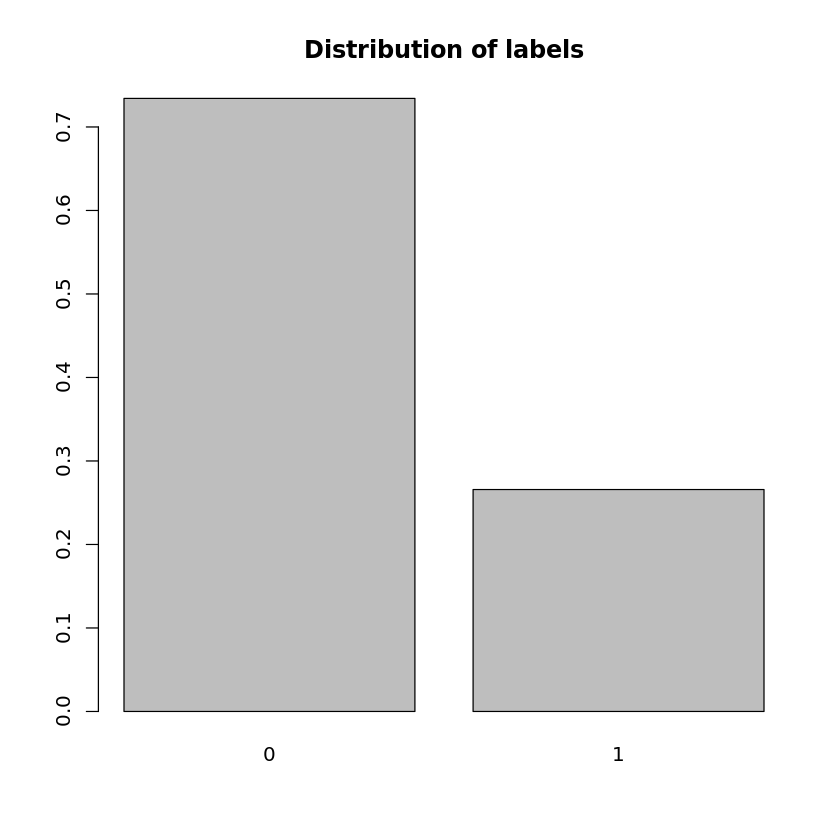

In [ ]:
# Distribution of labels
barplot(prop.table(table(df$Churn)), main="Distribution of labels")

#### Correlation plot

In [ ]:
corrPlotDF <- df

In [ ]:
corrPlotDF$gender <- as.integer(corrPlotDF$gender)
corrPlotDF$SeniorCitizen <- as.integer(corrPlotDF$SeniorCitizen)
corrPlotDF$MultipleLines <- as.integer(corrPlotDF$MultipleLines)
corrPlotDF$OnlineSecurity <- as.integer(corrPlotDF$OnlineSecurity)
corrPlotDF$DeviceProtection <- as.integer(corrPlotDF$DeviceProtection)
corrPlotDF$TechSupport <- as.integer(corrPlotDF$TechSupport)
corrPlotDF$OnlineBackup <- as.integer(corrPlotDF$OnlineBackup)
corrPlotDF$StreamingMovies <- as.integer(corrPlotDF$StreamingMovies)
corrPlotDF$StreamingTV <- as.integer(corrPlotDF$StreamingTV)
corrPlotDF$PaperlessBilling <- as.integer(corrPlotDF$PaperlessBilling)
corrPlotDF$PhoneService <- as.integer(corrPlotDF$PhoneService)
corrPlotDF$Partner <- as.integer(corrPlotDF$Partner)
corrPlotDF$Dependents <- as.integer(corrPlotDF$Dependents)
corrPlotDF$Churn <- as.integer(corrPlotDF$Churn)

In [ ]:
str(corrPlotDF)

'data.frame':	7032 obs. of  27 variables:
 $ gender                        : int  1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen                 : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Partner                       : int  2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents                    : int  1 1 1 1 1 1 2 1 1 2 ...
 $ tenure                        : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService                  : int  1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines                 : int  1 1 1 1 1 2 2 1 2 1 ...
 $ InternetService.DSL           : int  1 1 1 1 0 0 0 1 0 1 ...
 $ InternetService.Fiber_optic   : int  0 0 0 0 1 1 1 0 1 0 ...
 $ InternetService.No            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ OnlineSecurity                : int  1 2 2 2 1 1 1 2 1 2 ...
 $ OnlineBackup                  : int  2 1 2 1 1 1 2 1 1 2 ...
 $ DeviceProtection              : int  1 2 1 2 1 2 1 1 2 1 ...
 $ TechSupport                   : int  1 1 1 2 1 1 1 1 2 1 ...
 $ StreamingTV                   : int  1 1 1 1 1 2 2 1 

In [ ]:
res <- cor(corrPlotDF)

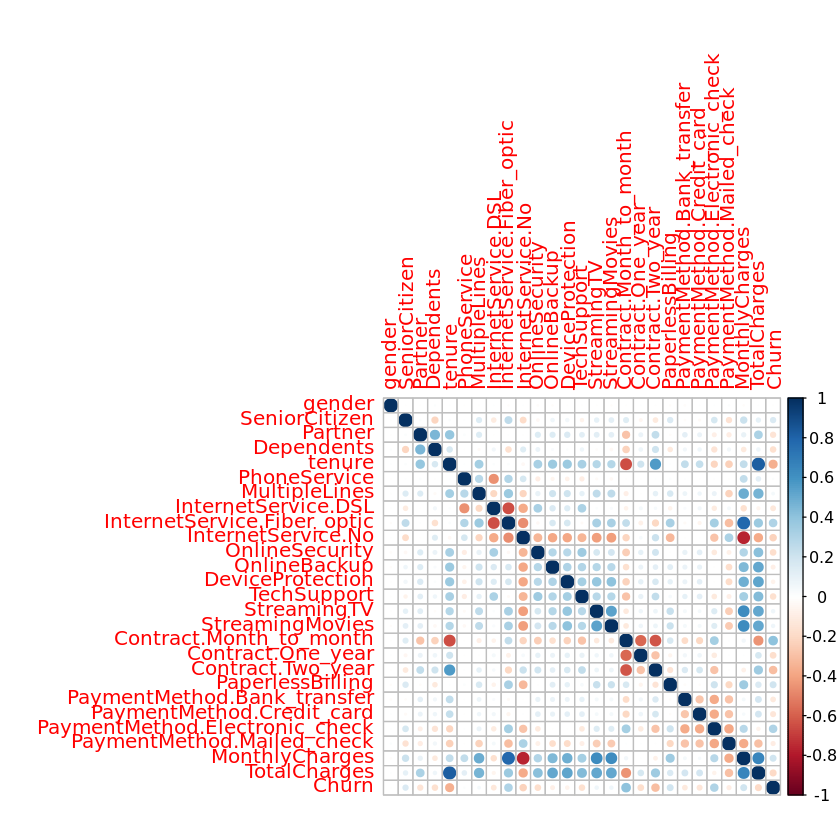

In [ ]:
corrplot(res,method="circle")

## Splitting data into training and validation set

In [ ]:
trainIndex <- createDataPartition(df$Churn, p = .7, # p=0.7: 70% of data is in training set, 
                                  list = FALSE,
                                  times = 1) # times = 1: we partition the data once

In [ ]:
train_data <- df[trainIndex, ]
validation_data <- df[-trainIndex, ]

## Modelling

### Helper functions

In [ ]:
# Code from another module
diagnosticsChurn = function(treemodel, testdata, threshold = 0.5){
  
  # uses the 'treemodel' to predict the 'Churn' using the 'testdata' and then it converts the predicted probabilities to binary depending on the specified threshold.
  fitted_results = predict(treemodel,testdata,type="prob")
  fitted_results_binary = factor(ifelse(fitted_results[,1] > threshold, 0,1), levels = c(0,1))
  # prints the confusion matrix
  print(confusionMatrix(fitted_results_binary, testdata$Churn, positive="1"))
  # creates a prediction object from the fitted results and the actual data
  pr = prediction(fitted_results[,1], testdata$Churn)
  # creates a performance rate and ROC curve to plot
  prf = performance(pr, measure = "tpr", x.measure = "fpr")
  #Calculates the area under the ROC curve
  # auc = performance(pr, measure = "auc")
  # auc = auc@y.values[[1]]
  # plot(prf, main = 'ROC curve', sub = paste('AUC:', round(auc,3) ))
  # abline(0,1, col = "red", lty = 3)
  # cat("AUC: ", auc, "\n")
  #   list(accuracy = CM$overall[1], auc = auc)
}

In [ ]:
importanceOfVariables = function(model) {
    # Gets the variables sorted by importance
    table <- varImp(model) %>% arrange(desc(Overall))
    # Prints top 6 variables
    head(table)
}

### Decision tree

In [ ]:
treemodel = rpart(Churn ~ .,
                  data = train_data,
                  method = "class",
                  control = rpart.control(maxsurrogate = 0))

In [ ]:
diagnosticsChurn(treemodel, validation_data)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1374  290
         1  174  270
                                          
               Accuracy : 0.7799          
                 95% CI : (0.7616, 0.7974)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 7.956e-07       
                                          
                  Kappa : 0.3959          
                                          
 Mcnemar's Test P-Value : 9.359e-08       
                                          
            Sensitivity : 0.4821          
            Specificity : 0.8876          
         Pos Pred Value : 0.6081          
         Neg Pred Value : 0.8257          
             Prevalence : 0.2657          
         Detection Rate : 0.1281          
   Detection Prevalence : 0.2106          
      Balanced Accuracy : 0.6849          
                                          
       'Positive' Class : 1               
                        

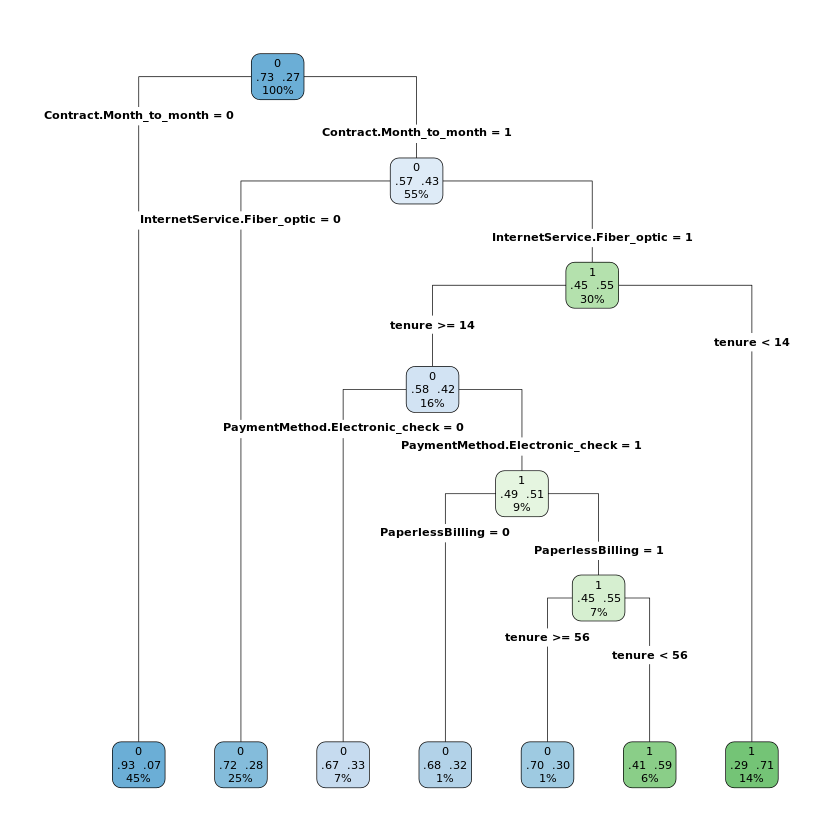

In [ ]:
rpart.plot(treemodel,type = 4,clip.right.labs = F,extra=104)

In [ ]:
# Drop column TotalCharges to prevent multicollinearity
# train_data <- subset(train_data, select = -c(TotalCharges))

In [ ]:
treemodel = rpart(Churn ~ .,
                  data = train_data,
                   method = "class",
                   control = rpart.control(maxsurrogate = 0))

In [ ]:
diagnosticsChurn(treemodel, validation_data)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1374  290
         1  174  270
                                          
               Accuracy : 0.7799          
                 95% CI : (0.7616, 0.7974)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 7.956e-07       
                                          
                  Kappa : 0.3959          
                                          
 Mcnemar's Test P-Value : 9.359e-08       
                                          
            Sensitivity : 0.4821          
            Specificity : 0.8876          
         Pos Pred Value : 0.6081          
         Neg Pred Value : 0.8257          
             Prevalence : 0.2657          
         Detection Rate : 0.1281          
   Detection Prevalence : 0.2106          
      Balanced Accuracy : 0.6849          
                                          
       'Positive' Class : 1               
                        

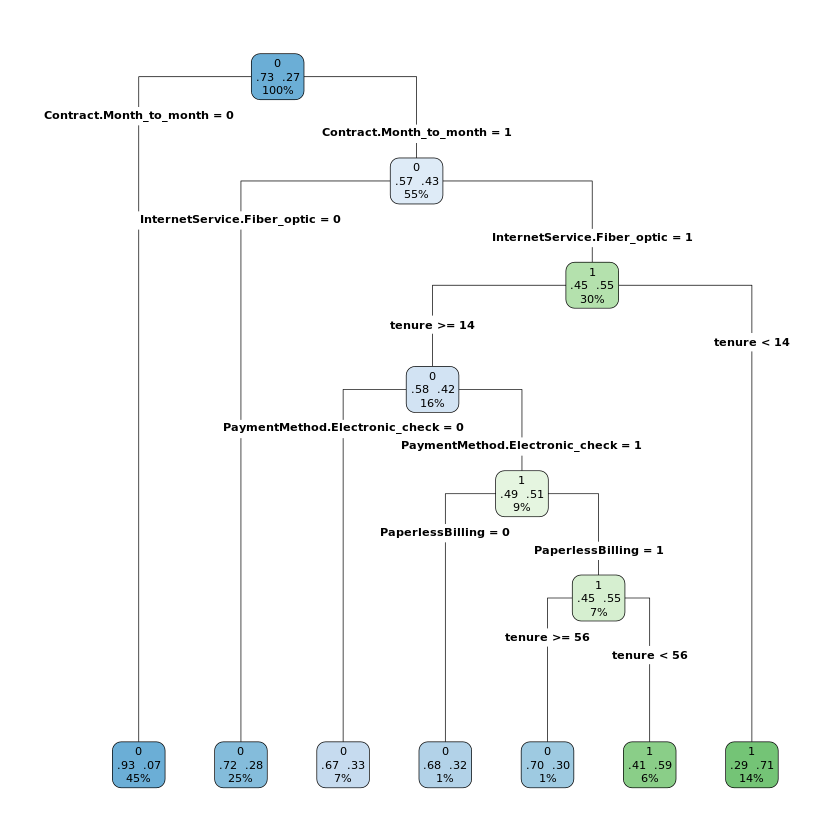

In [ ]:
rpart.plot(treemodel,type = 4,clip.right.labs = F,extra=104)

### Pruning decision tree


Classification tree:
rpart(formula = Churn ~ ., data = train_data, method = "class", 
    control = rpart.control(maxsurrogate = 0))

Variables actually used in tree construction:
[1] Contract.Month_to_month        InternetService.Fiber_optic   
[3] PaperlessBilling               PaymentMethod.Electronic_check
[5] tenure                        

Root node error: 1309/4924 = 0.26584

n= 4924 

        CP nsplit rel error  xerror     xstd
1 0.061497      0   1.00000 1.00000 0.023682
2 0.012605      3   0.78304 0.78304 0.021764
3 0.010000      6   0.74255 0.77082 0.021638


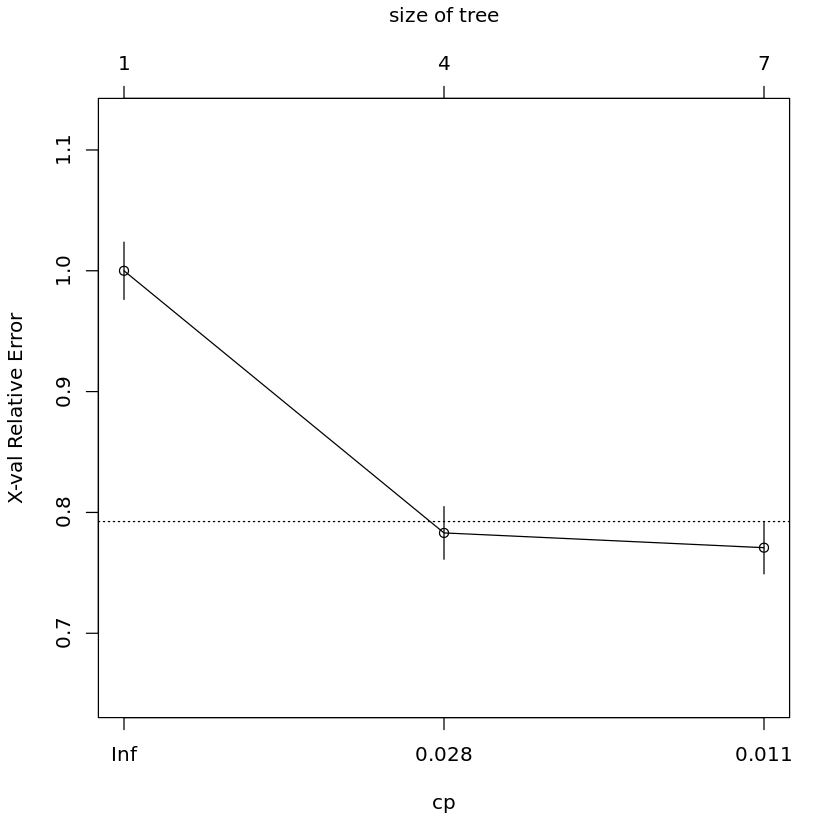

In [ ]:
printcp(treemodel)
plotcp(treemodel)

Call:
rpart(formula = Churn ~ ., data = train_data, method = "class", 
    control = rpart.control(maxsurrogate = 0))
  n= 4924 

          CP nsplit rel error    xerror       xstd
1 0.06149733      0 1.0000000 1.0000000 0.02368238
2 0.03500000      3 0.7830405 0.7830405 0.02176406

Variable importance
    Contract.Month_to_month InternetService.Fiber_optic 
                         67                          20 
                     tenure 
                         13 

Node number 1: 4924 observations,    complexity param=0.06149733
  predicted class=0  expected loss=0.2658408  P(node) =1
    class counts:  3615  1309
   probabilities: 0.734 0.266 
  left son=2 (2227 obs) right son=3 (2697 obs)
  Primary splits:
      Contract.Month_to_month        < 0.5    to the left,  improve=324.7285, (0 missing)
      tenure                         < 15.5   to the right, improve=209.1174, (0 missing)
      InternetService.Fiber_optic    < 0.5    to the left,  improve=180.3722, (0 missing)
     

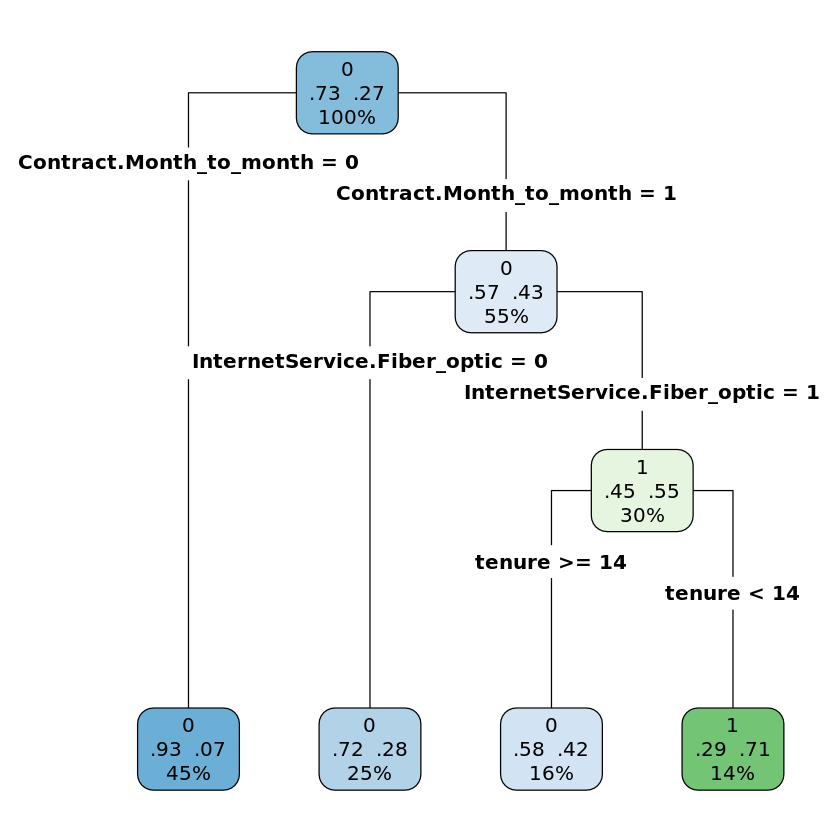

In [ ]:
treemodel_prune = prune(treemodel, cp = 0.035, minsplit = 350, maxdepth = 3)
rpart.plot(treemodel_prune,type = 4,clip.right.labs = F,extra=104)
summary_model = summary(treemodel_prune)

diagnosticsChurn(treemodel_prune, validation_data)


In [ ]:
importanceOfVariables(treemodel_prune)

,Overall
,<dbl>
Contract.Month_to_month,324.72850
tenure,322.98932
InternetService.Fiber_optic,279.68488
PaymentMethod.Electronic_check,259.02256
Contract.Two_year,179.16891
MonthlyCharges,74.18042


### Bagging

In [ ]:
churnBag = bagging(Churn ~., data = train_data, nbagg = 25)
diagnosticsChurn(churnBag, validation_data)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1377  280
         1  171  280
                                          
               Accuracy : 0.7861          
                 95% CI : (0.7679, 0.8034)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 2.256e-08       
                                          
                  Kappa : 0.4153          
                                          
 Mcnemar's Test P-Value : 3.666e-07       
                                          
            Sensitivity : 0.5000          
            Specificity : 0.8895          
         Pos Pred Value : 0.6208          
         Neg Pred Value : 0.8310          
             Prevalence : 0.2657          
         Detection Rate : 0.1328          
   Detection Prevalence : 0.2139          
      Balanced Accuracy : 0.6948          
                                          
       'Positive' Class : 1               
                        

In [ ]:
importanceOfVariables(churnBag)

,Overall
,<dbl>
tenure,948.5940
TotalCharges,944.9780
MonthlyCharges,943.1043
PaymentMethod.Electronic_check,394.7032
Contract.Month_to_month,321.2680
InternetService.Fiber_optic,295.6880


### Random forest

In [ ]:
set.seed(123)

In [ ]:
rf <- randomForest(Churn ~ ., data=train_data)

In [ ]:
diagnosticsChurn(rf, validation_data)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e98d80dd-e998-4fe6-9896-58109e021771' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>